In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision

tcmalloc: large alloc 1073750016 bytes == 0x587d4000 @  0x7f3830f1f2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import numpy as np
import gzip
import struct
import pickle
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import transforms

In [7]:
import urllib.request

urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "train_features.gz")
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "test_features.gz")


def get_features(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
def plot_image(image):
    plt.imshow(image.reshape((28,28)), cmap="gray")
    
features = get_features("train_features.gz").reshape((60000, 1,28,28)) / 255
features = torch.from_numpy(features).float().cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


In [0]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    
    #encoder
    self.e_cnn1 = nn.Conv2d(1,1,(3,3))
    self.e_cnn2 = nn.Conv2d(1,1,(3,3))
    self.e_cnn3 = nn.Conv2d(1,1,(3,3))
    self.e_dense_mean = nn.Linear(484, 30)
    
    #decoder
    self.d_dense = nn.Linear(30,484)
    self.d_decnn1 = nn.ConvTranspose2d(1,1,(3,3))
    self.d_decnn2 = nn.ConvTranspose2d(1,1,(3,3))
    self.d_decnn3 = nn.ConvTranspose2d(1,1,(3,3))
    
  
  def forward(self, input, generating=False):
    # encoding
    mean, var = None, None
    if not generating: 
      res = self.relu(self.e_cnn1(input))
      res = self.relu(self.e_cnn2(res))
      res = self.relu(self.e_cnn3(res))
      res = res.reshape(input.shape[0], 484)
      mean = self.relu(self.e_dense_mean(res))
      samples = torch.randn_like(mean)
      input = mean + samples
    
    # decoding
    res = self.relu(self.d_dense(input))
    res = res.reshape(input.shape[0], 1 , 22, 22)
    res = self.relu(self.d_decnn1(res))
    res = self.relu(self.d_decnn2(res))
    res = self.sigmoid(self.d_decnn3(res))
    return (res,mean)

In [0]:
net = VAE().cuda()

In [0]:
epochs = 100

optimizer = optim.Adam(net.parameters())

for i in range(epochs):
  generated, mean = net(features)
  loss_reconstruct = (((features - generated) ** 2)).sum() / 60000
  loss_KL = mean.pow(2).sum() * 0.005 /60000
  loss = (loss_reconstruct + loss_KL)
  loss.backward()
  optimizer.step()
  print("epoch: ", i)
  print("reconstruct loss: ", loss_reconstruct.item())
  print("KL: ", loss_KL.item())
  print("___________")

epoch:  0
reconstruct loss:  198.1804962158203
KL:  0.00011291839473415166
___________
epoch:  1
reconstruct loss:  197.7943572998047
KL:  0.00014345782983582467
___________
epoch:  2
reconstruct loss:  197.4279022216797
KL:  0.00022335008543450385
___________
epoch:  3
reconstruct loss:  197.06854248046875
KL:  0.0003603340592235327
___________
epoch:  4
reconstruct loss:  196.71388244628906
KL:  0.0005672809202224016
___________
epoch:  5
reconstruct loss:  196.36245727539062
KL:  0.0008618477149866521
___________
epoch:  6
reconstruct loss:  196.01177978515625
KL:  0.0012641028733924031
___________
epoch:  7
reconstruct loss:  195.6618194580078
KL:  0.0017958335811272264
___________
epoch:  8
reconstruct loss:  195.3141632080078
KL:  0.0024821353144943714
___________
epoch:  9
reconstruct loss:  194.96722412109375
KL:  0.0033464173320680857
___________
epoch:  10
reconstruct loss:  194.62088012695312
KL:  0.0043984269723296165
___________
epoch:  11
reconstruct loss:  194.2762451171

torch.Size([1, 1, 28, 28])

In [0]:
from matplotlib import pyplot as plt
def plot_image(image):
    plt.imshow(image.detach().cpu().numpy().reshape((28,28)) * 255, cmap="gray")

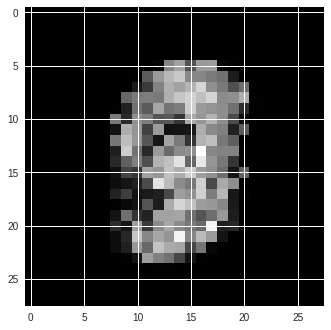

In [49]:
sample = net(torch.randn(100).cuda(), generating=True)[0]
plot_image(sample)